# 预测Kaggle上的房价
:label:`sec_kaggle_house`

现在我们已经介绍了一些构建和训练深度网络的基本工具，以及使用包括权重衰减和dropout在内的技术进行正则化，我们已经准备好将所有这些知识付诸实践，通过参加Kaggle竞赛。房价预测竞赛是一个很好的起点。数据相当通用，并且没有表现出可能需要专门模型的奇异结构（如音频或视频）。该数据集由:citet:`De-Cock.2011`收集，涵盖了2006-2010年艾奥瓦州埃姆斯市的房价。它比著名的Harrison和Rubinfeld (1978)的[Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)要大得多，拥有更多的样本和特征。

在本节中，我们将带你详细了解数据预处理、模型设计和超参数选择。我们希望通过这种动手的方法，你能获得一些直觉，这将在你作为数据科学家的职业生涯中指导你。

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 下载数据

在本书中，我们将在各种下载的数据集上训练和测试模型。
这里，我们（**实现两个实用函数**）用于下载和解压zip或tar文件。
同样，我们略过这些实用函数的实现细节。

In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Kaggle

[Kaggle](https://www.kaggle.com) 是一个广受欢迎的平台，举办机器学习竞赛。每个竞赛都围绕一个数据集进行，许多竞赛由提供奖金给优胜解决方案的利益相关者赞助。该平台帮助用户通过论坛和共享代码互动，促进合作与竞争。虽然追逐排行榜常常导致失控，研究人员过于专注于预处理步骤而忽略了基本问题，但这个平台也有巨大的价值，它促进了不同方法之间的直接定量比较以及代码共享，使每个人都能了解哪些方法有效，哪些无效。如果你想参加Kaggle竞赛，首先需要注册一个账户（见 :numref:`fig_kaggle`）。

![The Kaggle website.](../img/kaggle.png)
:width:`400px`
:label:`fig_kaggle`

在房价预测竞赛页面上，如 :numref:`fig_house_pricing` 所示，你可以找到数据集（在“数据”标签下）、提交预测并查看你的排名。网址如下：

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](../img/house-pricing.png)
:width:`400px`
:label:`fig_house_pricing`

## 访问和读取数据集

请注意，比赛数据被分为训练集和测试集。每条记录包括房屋的财产价值以及街道类型、建造年份、屋顶类型、地下室状况等属性。特征包含各种数据类型。例如，建造年份用整数表示，屋顶类型用离散类别分配表示，其他特征则用浮点数表示。而实际情况会更加复杂：对于某些样本，部分数据完全缺失，缺失值简单标记为 "na"。仅训练集中包含了每栋房子的价格（毕竟这是一场比赛）。我们将希望将训练集划分以创建验证集，但我们只能在上传预测结果到Kaggle后才能在官方测试集上评估我们的模型。:numref:`fig_house_pricing` 中比赛页面的“数据”标签有下载数据的链接。

开始时，我们将使用 `pandas` 读取和处理数据，我们在 :numref:`sec_pandas` 中介绍过它。为了方便起见，我们可以下载并缓存Kaggle住房数据集。如果缓存目录中已存在与此数据集对应的文件且其SHA-1与`sha1_hash`匹配，我们的代码将使用缓存文件以避免重复下载占用网络资源。

In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

训练数据集包含1460个样本、80个特征和一个标签，而验证数据包含1459个样本和80个特征。

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## 数据预处理

让我们[**看看前四个和最后两个特征
以及标签（SalePrice）**]来自前四个示例。

In [5]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个示例中，第一个特征是标识符。
这有助于模型确定每个训练示例。
虽然这很方便，但它不携带任何用于预测的信息。
因此，在将数据输入模型之前，我们将从数据集中移除它。
此外，鉴于数据类型多种多样，
我们需要在开始建模前对数据进行预处理。

让我们从数值特征开始。
首先，我们应用一个启发式方法，
[**用相应特征的均值替换所有缺失值。**]
然后，为了将所有特征放在一个共同的尺度上，
我们（***通过将特征重新缩放到零均值和单位方差来*标准化*数据**）：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中$\mu$和$\sigma$分别表示均值和标准差。
为了验证这确实将我们的特征（变量）转换为零均值和单位方差，
注意$E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
并且$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
直观地讲，我们标准化数据有两个原因。
首先，这对优化很有帮助。
其次，因为我们事先不知道哪些特征相关，
我们不想比其他特征更多地惩罚分配给某个特征的系数。

[**接下来我们处理离散值。**]
这些包括诸如"MSZoning"这样的特征。
（**我们用独热编码替换它们**）
就像我们早先将多类标签转换成向量一样（见:numref:`subsec_classification-problem`）。
例如，“MSZoning”假定值为“RL”和“RM”。
去掉“MSZoning”特征后，
创建两个新的指示器特征
“MSZoning_RL”和“MSZoning_RM”，其值分别为0或1。
根据独热编码，
如果“MSZoning”的原始值是“RL”，
那么“MSZoning_RL”是1，“MSZoning_RM”是0。
`pandas`包为我们自动完成这一过程。

In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

你可以看到，这个转换将特征数量从79增加到了331（不包括ID和标签列）。

In [7]:
data.preprocess()
data.train.shape

(1460, 331)

## 误差度量

为了开始，我们将用平方损失训练一个线性模型。不出所料，我们的线性模型不会带来赢得比赛的提交，但它确实提供了一个检查点，以查看数据中是否有有意义的信息。如果我们在这里的表现不能优于随机猜测，那么很可能我们有一个数据处理错误。如果一切顺利，线性模型将作为一个基准，给我们一些直觉，了解简单模型与最佳报告模型之间的接近程度，从而让我们对从更复杂的模型中应期待多少增益有所感知。

对于房价，就像股价一样，
我们更关心相对数量
而不是绝对数量。
因此[**我们更关心相对误差 $\frac{y - \hat{y}}{y}$**]
而非绝对误差 $y - \hat{y}$。
例如，如果我们在估计俄亥俄州农村的一栋房子的价格时预测偏差为100,000美元，
而那里一栋典型房子的价值是125,000美元，
那么我们可能做得非常糟糕。
另一方面，如果我们在加利福尼亚州洛斯阿尔托斯山犯同样的错误，
这可能代表了惊人的准确预测
（那里的中位数房价超过了400万美元）。

(**解决这个问题的一种方法是
测量价格估计值对数之间的差异。**)
事实上，这也是比赛中用来评估提交质量的官方误差度量标准。
毕竟，$|\log y - \log \hat{y}| \leq \delta$ 的一个小值 $\delta$
转换为 $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这导致了预测价格对数与标签价格对数之间的以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

## $K$-折交叉验证

你可能还记得我们在 :numref:`subsec_generalization-model-selection` 中介绍了[**交叉验证**]，讨论了如何处理模型选择。我们将充分利用这一点来选择模型设计并调整超参数。我们首先需要一个函数，该函数在$K$-折交叉验证过程中返回第$i$折的数据。它通过将第$i$段切片作为验证数据，并返回其余部分作为训练数据来进行。请注意，这不是处理数据的最有效方法，如果我们的数据集大得多，我们肯定会做一些更聪明的事情。但由于问题的简单性，这里我们可以安全地省略这些复杂性，以免使代码变得不必要地复杂。

In [9]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

[**返回平均验证误差**]
当我们进行$K$折交叉验证中的$K$次训练时。

In [10]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

## [**模型选择**]

在这个例子中，我们选择了一组未经调优的超参数
并将改进模型的任务留给读者。
找到一个好的选择可能需要时间，
这取决于优化的变量数量。
对于足够大的数据集，
以及通常类型的超参数，
$K$-折交叉验证往往能够
合理地抵御多次测试的影响。
然而，如果我们尝试了不合理的大量选项，
我们可能会发现验证性能
不再能代表真正的误差。

average validation log mse = 0.18467878937721252


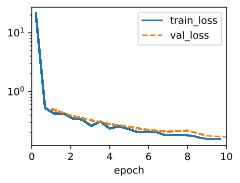

In [11]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

请注意，有时对于一组超参数，训练错误的数量可能非常少，即使$K$折交叉验证的错误数量显著增加。这表明我们正在过拟合。在整个训练过程中，您需要同时监控这两个数字。较少的过拟合可能意味着我们的数据可以支持一个更强大的模型。严重的过拟合可能表明我们可以通过引入正则化技术来获得改进。

##  [**在Kaggle上提交预测结果**]

现在我们知道一个好的超参数选择应该是什么样的，我们可以
计算所有$K$个模型对测试集的平均预测。
将预测保存在一个csv文件中
将简化上传结果到Kaggle的过程。
以下代码将生成一个名为`submission.csv`的文件。

In [12]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

接下来，如:numref:`fig_kaggle_submit2`所示，
我们可以在Kaggle上提交我们的预测结果，
并查看它们与测试集上的实际房价（标签）相比如何。
步骤非常简单：

* 登录Kaggle网站并访问房价预测竞赛页面。
* 点击“提交预测”或“延迟提交”按钮。
* 点击页面底部虚线框中的“上传提交文件”按钮，并选择你希望上传的预测文件。
* 点击页面底部的“进行提交”按钮以查看你的结果。

![向Kaggle提交数据](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## 总结和讨论

真实数据通常包含不同类型的数据，需要进行预处理。
将实数值数据重新缩放到零均值和单位方差是一个很好的默认设置。用均值替换缺失值也是如此。
此外，将分类特征转换为指示特征使我们可以像对待one-hot向量一样对待它们。
当我们更关心相对误差而不是绝对误差时，
我们可以
测量预测值对数的差异。
为了选择模型和调整超参数，
我们可以使用$K$-折交叉验证。



## 练习

1. 将本节的预测提交到Kaggle。它们有多好？
1. 用均值替换缺失值总是个好主意吗？提示：你能构造一个缺失值不是随机的情况吗？
1. 通过$K$-折交叉验证调整超参数来提高分数。
1. 通过改进模型（例如，层数、权重衰减和dropout）来提高分数。
1. 如果我们不对连续数值特征进行标准化会发生什么？

[讨论](https://discuss.d2l.ai/t/107)